VisImportance : Learning Visual Importance for Graphic Designs and Data Visualizations

Source code by Zoya Bylinskii et al. with Caffe AI models : https://github.com/cvzoya/visimportance

Zoya Bylinskii, Nam Wook Kim, Peter O'Donovan, Sami Alsheikh, Spandan Madan, Hanspeter Pfister, Fredo Durand, Bryan Russell, and Aaron Hertzmann. "Learning Visual Importance for Graphic Designs and Data Visualizations" (UIST'17)

Adapted by Egor Abaturov to use PyTorch : https://github.com/egorabaturov/visimportance-in-pytorch
Converted to iPython Jupyter Notebook by Laurent Jégou (https://ljegou.github.io/)

Usage : 
- Change the image_url below to use with one of your images
- Choose one of the pretrained models
- Execute the notebook
- Allow time to download the pretrained model, the first time
- You can download the result image with a ricght click

In [43]:
import os
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from scipy.special import expit
import torch
from torch.autograd import Variable
import torch.utils.model_zoo as model_zoo
import models
import requests
import urllib.request

In [40]:
# Change the pretrained model as desired : gdi_fcn16, gdi_fcn32 or massvis32
pretrained_model_url = 'https://www.geotests.net/depot/gdi_fcn16.pth'
fcn_type = 'fcn16'  # 'fcn32'
# Insert here the path to the source image to analyse
image_url = 'https://www.geotests.net/test/umsi/base_qb.jpg'

In [41]:
# Functions to load, copy and overlay images
def load_img(image_url):
    img_brute = requests.get(image_url, stream=True).raw
    img = PIL.Image.open(img_brute)
    img = np.array(img, dtype=np.uint8)

    return img

def transform_img(img):
    mean_bgr = np.array([104.00699, 116.66877, 122.67892])

    img_copy = img.copy()
    img_copy = img_copy[:, :, ::-1]  # RGB -> BGR
    img_copy = img_copy.astype(np.float32)
    img_copy -= mean_bgr
    img_copy = img_copy.transpose(2, 0, 1)  # C x H x W
    img_copy = torch.from_numpy(img_copy).float()

    return img_copy

def overlay_imp_on_img(img: object, imp: object, colormap: object = 'viridis') -> object:

    cm = plt.get_cmap(colormap) # https://matplotlib.org/examples/color/colormaps_reference.html
    img2 = np.array(img, dtype=np.uint8)
    imp2 = np.array(imp, dtype=np.uint8)
    imp3 = (cm(imp2)[:, :, :3] * 255).astype(np.uint8)
    img3 = PIL.Image.fromarray(img2)
    imp3 = PIL.Image.fromarray(imp3)

    im_alpha = PIL.Image.blend(img3, imp3, 0.5)
    return(im_alpha)

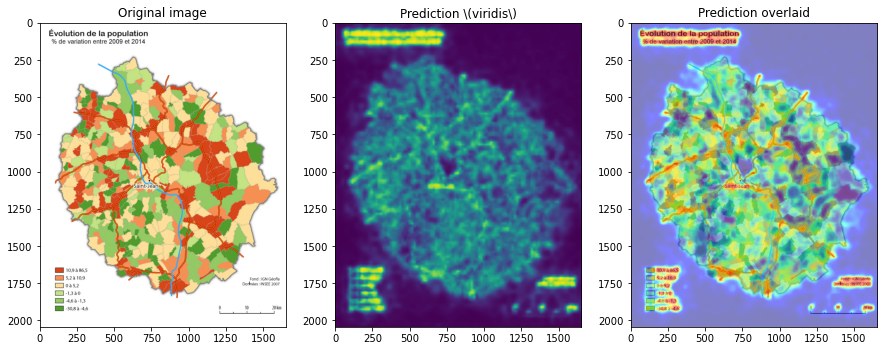

In [44]:
# Main program, predict visual importance on image
img = load_img(image_url)
img_transformed = transform_img(img)[np.newaxis]
model = models.FCN32s() if fcn_type == 'fcn32' else models.FCN16s()
map_location = lambda storage, loc: storage
model.load_state_dict(model_zoo.load_url(pretrained_model_url, map_location=map_location))
with torch.no_grad():
    img_transformed = Variable(img_transformed)
score = model(img_transformed)
lbl_pred = (expit(score.data.cpu().numpy()) * 255).astype(np.uint8)[0][0]

img_overlay = overlay_imp_on_img(img, lbl_pred, colormap='jet')
k = 3
    
# Show the results with a composite image
plt.figure(figsize=[15,15])
plt.subplot(1,k,1)
plt.imshow(img)
plt.title("Original image")
plt.subplot(1,k,2)
plt.imshow(lbl_pred)
plt.title("Prediction")
plt.subplot(1,k,3)
plt.imshow(img_overlay)
plt.title("Prediction overlaid")
    
plt.show()